In [5]:
from __future__ import division
import numpy as np
import random as rnd

k = 1.5
dt = 0.01
nsteps = 20000
nsteps_relax = 0
nrun = 300
window_size = 10
thres = 0.75

# RUNGE–KUTTA ESTOCÁSTICO  

def rk4_step(ux, uy, ks, dt):

    sigma = 1 / np.sqrt(dt)

    def drift(u):
        x, y = u
        vx = -ks*x - y
        vy = -ks*y + x
        return np.array([vx, vy])

    noise = sigma * np.random.normal(0, 1, 2)

    k1 = drift([ux, uy]) + noise
    k2 = drift([ux + 0.5*dt*k1[0], uy + 0.5*dt*k1[1]]) + noise
    k3 = drift([ux + 0.5*dt*k2[0], uy + 0.5*dt*k2[1]]) + noise
    k4 = drift([ux + dt*k3[0], uy + dt*k3[1]]) + noise

    du = dt * (k1 + 2*k2 + 2*k3 + k4) / 6.0
    return ux + du[0], uy + du[1], du[0]/dt, du[1]/dt

def integrate_motion(nsteps_relax, nsteps, dt, ks):

    ux = rnd.gauss(0,1)/np.sqrt(2*ks)
    uy = rnd.gauss(0,1)/np.sqrt(2*ks)

    for _ in range(nsteps_relax):
        ux, uy, _, _ = rk4_step(ux, uy, ks, dt)

    ux_arr = np.zeros(nsteps)
    uy_arr = np.zeros(nsteps)
    vx_arr = np.zeros(nsteps)
    vy_arr = np.zeros(nsteps)

    for i in range(nsteps):
        ux, uy, vx, vy = rk4_step(ux, uy, ks, dt)
        ux_arr[i] = ux
        uy_arr[i] = uy
        vx_arr[i] = vx
        vy_arr[i] = vy

    vnorm = np.sqrt(vx_arr**2 + vy_arr**2)
    vorix = vx_arr / vnorm
    voriy = vy_arr / vnorm

    return ux_arr, uy_arr, vx_arr, vy_arr, vnorm, vorix, voriy

# ÁNGULO Y SPIN 

def compute_theta(dt, vx, vy):

    theta_corr = np.zeros(len(vx))
    theta_corr[0] = np.arctan2(vy[0], vx[0])

    nber_loop = 0
    spin = []
    t_spin = []

    for i in range(1,len(vx)):
        raw = np.arctan2(vy[i], vx[i])
        trials = [raw + nber_loop*2*np.pi,
                  raw + (nber_loop+1)*2*np.pi,
                  raw + (nber_loop-1)*2*np.pi]

        ksel = np.argmin(np.abs(np.array(trials)-theta_corr[i-1]))
        theta_corr[i] = trials[ksel]

        if ksel == 1:
            nber_loop += 1
        elif ksel == 2:
            nber_loop -= 1

        eps = 1 if theta_corr[i] > theta_corr[i-1] else -1

        if i < 2:
            spin.append(eps)
            t_spin.append(0)
        else:
            if eps*spin[-1] < 0:
                spin.append(eps)
                t_spin.append(i-1)

    return theta_corr, spin, t_spin

# MATRICES

ux_arr_all = np.zeros((nsteps,nrun))
uy_arr_all = np.zeros((nsteps,nrun))
vx_arr_all = np.zeros((nsteps,nrun))
vy_arr_all = np.zeros((nsteps,nrun))
spectrum_all = np.zeros((nsteps,nrun))

freq = np.fft.fftfreq(nsteps, dt)


for j in range(nrun):

    ux, uy, vx, vy, vnorm, vorix, voriy = integrate_motion(
        nsteps_relax, nsteps, dt, k
    )

    ux_arr_all[:,j] = ux
    uy_arr_all[:,j] = uy
    vx_arr_all[:,j] = vx
    vy_arr_all[:,j] = vy

    spectrum_all[:,j] = np.abs(np.fft.fft(vx))**2 + np.abs(np.fft.fft(vy))**2
    
# PROMEDIO BÁSICO

spectrum = spectrum_all.mean(axis=1) / nsteps

J = np.argsort(freq)
freq_sorted = freq[J]
spectrum = spectrum[J]

smooth = np.convolve(spectrum, np.ones(2*window_size+1)/(2*window_size+1), mode="same")

maxS = np.max(smooth)
minS = smooth[np.argmin(np.abs(freq_sorted))]

window_arr = np.zeros(nsteps)
for i in range(nsteps):
    if maxS - smooth[i] < (1-thres)*(maxS-minS):
        idx = np.argmin(np.abs(freq - freq_sorted[i]))
        window_arr[idx] = 1

fmin = np.min(np.abs(freq[window_arr>0]))
fmax = np.max(np.abs(freq[window_arr>0]))

window_arr = ((np.abs(freq)>fmin) & (np.abs(freq)<fmax)).astype(float)


def stderr_mean(mat):
    return np.std(mat, axis=1, ddof=1) / np.sqrt(mat.shape[1])

# desplazamiento
spectrum_disp_all = np.abs(np.fft.fft(ux_arr_all, axis=0))**2 + \
                    np.abs(np.fft.fft(uy_arr_all, axis=0))**2

# orientación
vnorm_all = np.sqrt(vx_arr_all**2 + vy_arr_all**2)
vorix_all = vx_arr_all / (vnorm_all + 1e-16)
voriy_all = vy_arr_all / (vnorm_all + 1e-16)
spectrum_ori_all = np.abs(np.fft.fft(vorix_all, axis=0))**2 + \
                   np.abs(np.fft.fft(voriy_all, axis=0))**2

# norma al cuadrado
v2_all = vx_arr_all**2 + vy_arr_all**2
spectrum_norm2_all = np.abs(np.fft.fft(v2_all, axis=0))**2

spectrum_disp = spectrum_disp_all.mean(axis=1)/nsteps
spectrum_ori  = spectrum_ori_all.mean(axis=1)/nsteps
spectrum_norm2 = spectrum_norm2_all.mean(axis=1)/nsteps
spectrum_v = spectrum_all.mean(axis=1)/nsteps


u_spectrum_disp  = stderr_mean(spectrum_disp_all)/nsteps
u_spectrum_ori   = stderr_mean(spectrum_ori_all)/nsteps
u_spectrum_norm2 = stderr_mean(spectrum_norm2_all)/nsteps
u_spectrum_v     = stderr_mean(spectrum_all)/nsteps

# ordenar
spectrum_disp = spectrum_disp[J]
spectrum_ori = spectrum_ori[J]
spectrum_norm2 = spectrum_norm2[J]
spectrum_v = spectrum_v[J]

u_spectrum_disp = u_spectrum_disp[J]
u_spectrum_ori = u_spectrum_ori[J]
u_spectrum_norm2 = u_spectrum_norm2[J]
u_spectrum_v = u_spectrum_v[J]

# Probabilidades de spin 

proba_plus_runs = np.zeros(nrun)
proba_minus_runs = np.zeros(nrun)

for j in range(nrun):
    vx_f = np.real(np.fft.ifft(window_arr * np.fft.fft(vx_arr_all[:,j])))
    vy_f = np.real(np.fft.ifft(window_arr * np.fft.fft(vy_arr_all[:,j])))
    _, spin, t_spin = compute_theta(dt, vx_f, vy_f)

    if len(spin) == 0:
        continue

    t = list(t_spin) + [nsteps]
    plus = 0
    minus = 0
    for i_s in range(len(spin)):
        dur = t[i_s+1] - t[i_s]
        if spin[i_s] > 0:
            plus += dur
        else:
            minus += dur

    proba_plus_runs[j] = plus/(nsteps-1)
    proba_minus_runs[j] = minus/(nsteps-1)

proba_plus = proba_plus_runs.mean()
proba_minus = proba_minus_runs.mean()
u_proba_plus = proba_plus_runs.std(ddof=1)/np.sqrt(nrun)
u_proba_minus = proba_minus_runs.std(ddof=1)/np.sqrt(nrun)

# ---- Guardar archivos -----------------------------------------

np.savetxt('Kspectrum_ori_k{0:.1f}.txt'.format(k),
           np.vstack((2*np.pi*freq_sorted, spectrum_ori, u_spectrum_ori)).T,
           header='w   S^v   u(S^v)')

np.savetxt('Kspectrum_norm2_k{0:.1f}.txt'.format(k),
           np.vstack((2*np.pi*freq_sorted, spectrum_norm2, u_spectrum_norm2)).T,
           header='w   Sv2   u(Sv2)')

np.savetxt('Kspectrum_k{0:.1f}.txt'.format(k),
           np.vstack((2*np.pi*freq_sorted, spectrum_v, u_spectrum_v)).T,
           header='w   Sv   u(Sv)')

np.savetxt('Kspectrum_disp_k{0:.1f}.txt'.format(k),
           np.vstack((2*np.pi*freq_sorted, spectrum_disp, u_spectrum_disp)).T,
           header='w   Su   u(Su)')

np.savetxt('Kproba_spin_k{0:.1f}.txt'.format(k),
           np.vstack((np.array([-1., 1.]),
                      np.array([proba_minus, proba_plus]),
                      np.array([u_proba_minus, u_proba_plus]))).T,
           header='eps   P(eps)   u(P(eps))')

print("Simulación completa.")
print("P(spin +)= {:.6f} ± {:.6f}".format(proba_plus, u_proba_plus))
print("P(spin -)= {:.6f} ± {:.6f}".format(proba_minus, u_proba_minus))


Simulación completa.
P(spin +)= 0.504815 ± 0.000202
P(spin -)= 0.495235 ± 0.000202


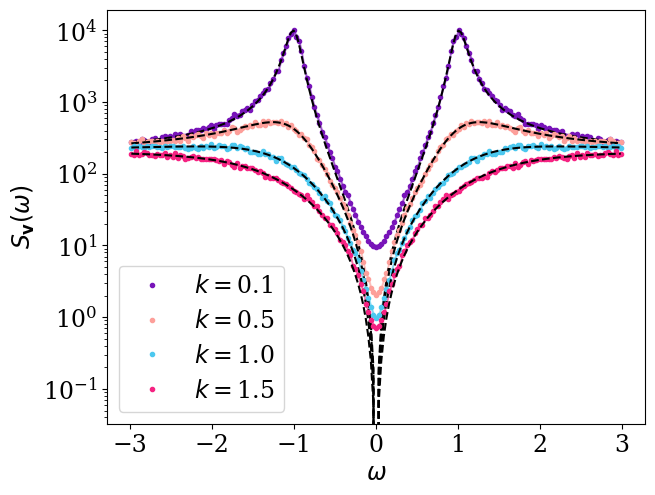

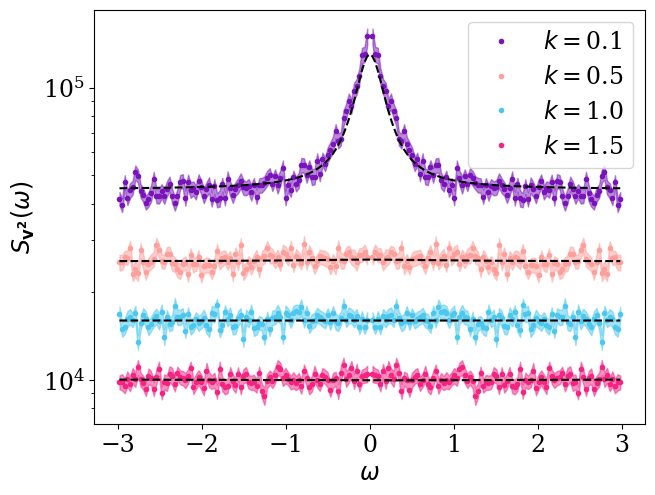

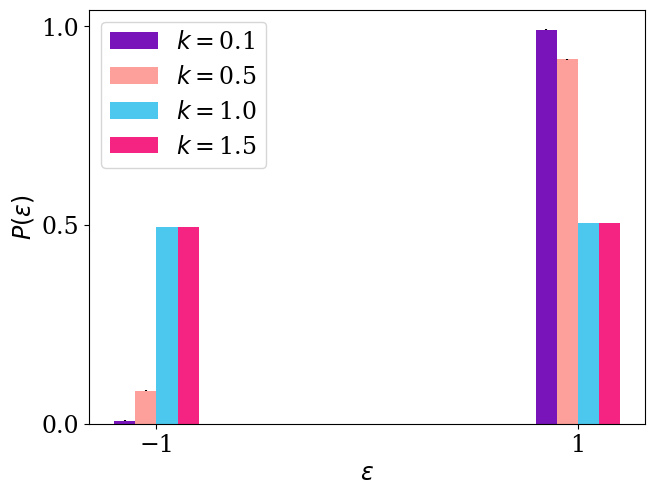

In [7]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

params = {'text.usetex' : False,
          'font.size' : 17,
          'font.family' : 'serif',
          }
plt.rcParams.update(params)
color_show = [ '#7814B9', '#FD9F9A', '#4CC8EF', '#F52382' ] 

# CURVES TO DISPLAY 

k_show = [ 0.1, 0.5, 1., 1.5 ] # values of the spring constant to display

# PLOT THE VELOCTY SPECTRUM 

def spectrum_vel(x, kk, a):

    return 2. * kk * a * x **2 * ( 1. + kk ** 2 + x ** 2 ) / ( kk ** 2 + ( x - 1. ) ** 2 ) / ( kk ** 2 + ( x + 1. ) ** 2 ) 

f, ax = plt.subplots()
ax.set_yscale('log')
k = 0
for kk in k_show:
    data = np.genfromtxt('Kspectrum_k{0:.1f}.txt'.format(kk))
    omega = data[:,0]
    spectrum = data[:,1]
    u_spectrum = data[:,2]
    spectrum = spectrum[np.absolute(omega) < 3.]
    u_spectrum = u_spectrum[np.absolute(omega) < 3.]
    omega = omega[np.absolute(omega) < 3.]
    ax.plot(omega, spectrum, marker = '.', linestyle = '', c = color_show[k], label = r'$k=${0:.1f}'.format(kk))
    ax.fill_between(omega, spectrum - u_spectrum, spectrum + u_spectrum, color = color_show[k], alpha = 0.5) 
    popt, pcov = curve_fit(lambda x, a: spectrum_vel(x, kk, a), omega, spectrum, np.amax(spectrum)) # find the best value of the amplitude to fit the numerical solution and the analytic solution
    ax.plot(omega, spectrum_vel(omega, kk, popt[0]), '--k')
    k += 1   
ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$S_\mathbf{v}(\omega)$')
maj_loc = ticker.LogLocator(numticks = 9)
min_loc = ticker.LogLocator(subs = 'all', numticks = 9)
ax.yaxis.set_major_locator(maj_loc)
ax.yaxis.set_minor_locator(min_loc)
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()

# PLOT THE SPECTRUM OF THE MAGNITUDE OF THE VELOCITY 

def spectrum_vel2(x, kk, a, b):

    return 4. * kk * a / ( 4. * kk ** 2 + x ** 2 ) + b

f, ax = plt.subplots()
ax.set_yscale('log')
k = 0
for kk in k_show:
    data = np.genfromtxt('Kspectrum_norm2_k{0:.1f}.txt'.format(kk))
    omega = data[:,0]
    spectrum = data[:,1] * 10 ** ( - k / 5. ) 
    u_spectrum = data[:,2] * 10 ** ( - k / 5. ) 
    spectrum[np.argmin(np.absolute(omega))] = 0. 
    spectrum = spectrum[np.absolute(omega) < 3.]
    u_spectrum = u_spectrum[np.absolute(omega) < 3.]
    omega = omega[np.absolute(omega) < 3.]
    ax.plot(omega[omega > 1e-5], spectrum[omega > 1e-5], marker = '.', linestyle = '', c = color_show[k], label = r'$k=${0:.1f}'.format(kk))
    ax.plot(omega[omega < - 1e-5], spectrum[omega < - 1e-5], marker = '.', linestyle = '', c = color_show[k])
    ax.fill_between(omega[omega > 1e-5], spectrum[omega > 1e-5] - u_spectrum[omega > 1e-5], spectrum[omega > 1e-5] + u_spectrum[omega > 1e-5], color = color_show[k], alpha = 0.5)
    ax.fill_between(omega[omega < - 1e-5], spectrum[omega < - 1e-5] - u_spectrum[omega < - 1e-5], spectrum[omega < - 1e-5] + u_spectrum[omega < - 1e-5], color = color_show[k], alpha = 0.5) 
    popt, pcov = curve_fit(lambda x, a, b: spectrum_vel2(x, kk, a, b), omega, spectrum, [ np.amax(spectrum), spectrum[-1] ]) # find the best value of the amplitude to fit the numerical solution and the analytic solution
    ax.plot(omega, spectrum_vel2(omega, kk, popt[0], popt[1]), '--k')
    k += 1   
ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$S_\mathbf{v^2}(\omega)$')
maj_loc = ticker.LogLocator(numticks = 9)
min_loc = ticker.LogLocator(subs = 'all', numticks = 9)
ax.yaxis.set_major_locator(maj_loc)
ax.yaxis.set_minor_locator(min_loc)
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()

# PLOT THE SPIN HISTOGRAM 

x = np.array([-1, 1])
bar_width = 0.1 
f, ax = plt.subplots()
k = 0
for kk in k_show:
    data = np.genfromtxt('Kproba_spin_k{0:.1f}.txt'.format(kk))
    proba = data[:,1]
    u_proba = data[:,2]
    ax.bar(x + ( k - ( len(k_show) - 1. ) * 0.5 ) * bar_width, proba, yerr = u_proba, width = bar_width, color = color_show[k], label = r'$k=${0:.1f}'.format(kk))
    k += 1
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$P(\epsilon)$')
ax.set_xticks([-1, 1])
ax.set_yticks([0, 0.5, 1])
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()
